# Code to process winter storm information

$\textbf{Introduction}$: The notebook contains code to process the input and output data for the European winter storm severe winds project. Specifically, we introduce a basic nested PC (Principal Components) Regression model with dropouts, and a Variational Encoder-Decoder (VEDs) to predict the quantile function (inversed CDF) of maximum surface wind gusts

The quantile function can be calculated from a given Cumulative Distribution Function (CDF) with the following equation:

$ Q = log_{10} (1 - CDF) $

The quantile function is particularly useful for our project because it accentuates the difference in distribution tail values. This property is useful in our context of predicting probabilities of rare severe winds in winter storms.

## Import relevant packages and data

In [1]:
! pip install optuna

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import os
import sys

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

util_perso = os.path.abspath(r'util\processing')
sys.path.append(util_perso)

from extraction_squares import split_storm_numbers

ImportError: dlopen(/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/PIL/_imaging.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/libtiff.5.dylib
  Referenced from: <0B366E58-2F25-3184-8E32-08DC64B33F7F> /Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/PIL/_imaging.cpython-311-darwin.so
  Reason: tried: '/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/PIL/../../../libtiff.5.dylib' (no such file), '/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/PIL/../../../libtiff.5.dylib' (no such file), '/Users/fabienaugsburger/anaconda3/envs/tensor_flow/bin/../lib/libtiff.5.dylib' (no such file), '/Users/fabienaugsburger/anaconda3/envs/tensor_flow/bin/../lib/libtiff.5.dylib' (no such file), '/usr/local/lib/libtiff.5.dylib' (no such file), '/usr/lib/libtiff.5.dylib' (no such file, not in dyld cache)

In [5]:
# Read the csv files for training time series (inputs)
all_input = pd.read_csv('./all_pca.csv')

# Read the csv files for processed quantile function outputs
output_quantile = pd.read_csv('./log_cdf_max_combined.csv')
output_quantile = output_quantile.drop(columns=['Unnamed: 0'])

## Check data
Let's do a prelimiary check to familiarize ourselves with the data first. What informations are stored in the csv files?

In [6]:
all_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23184 entries, 0 to 23183
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   storm_number  23184 non-null  int64  
 1   variable      23184 non-null  object 
 2   PCA_1         23184 non-null  float64
 3   PCA_2         17766 non-null  float64
 4   PCA_3         16569 non-null  float64
 5   PCA_4         12537 non-null  float64
 6   PCA_5         10962 non-null  float64
 7   PCA_6         10080 non-null  float64
 8   PCA_7         8694 non-null   float64
 9   PCA_8         7623 non-null   float64
 10  PCA_9         6300 non-null   float64
 11  PCA_10        5229 non-null   float64
 12  PCA_11        4410 non-null   float64
 13  PCA_12        4032 non-null   float64
 14  PCA_13        3150 non-null   float64
 15  PCA_14        2646 non-null   float64
 16  PCA_15        2079 non-null   float64
 17  PCA_16        693 non-null    float64
 18  PCA_17        441 non-null

The input csv files contain entries of different PC loadings associated with a particular physical variable. In this case, we see 3 different loadings associated with maximum 1000 hPa geopotential heights. Each row entry represents the time series shape characteristics for 1 storm.

In [7]:
output_quantile

,storm_number,storm_name,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14
0,9,C3S_STORM_TRACKS_ERA5,1.488954,1.250388,0.380618,1.935491,0.699998,0.792000,5.247844,2.087615,0.184377,0.598205,0.871613,1.370565,1.234141,1.991662,0.644461
1,35,C3S_STORM_TRACKS_ERA5,1.137745,0.711018,1.567827,2.084789,0.821490,0.400187,2.111582,0.319745,0.382948,0.103998,1.400420,2.058132,2.002799,0.173682,1.112621
2,82,C3S_STORM_TRACKS_ERA5,2.269466,1.354909,1.512206,1.765846,1.467819,2.437863,4.580985,1.600677,3.373869,0.564611,1.627736,2.772098,3.709723,1.785086,0.274402
3,1,C3S_STORM_TRACKS_ERA5,2.381500,0.522132,1.550332,3.086368,0.395841,0.069842,3.856062,0.118614,0.085295,0.005899,1.832467,1.065175,1.373891,0.205400,0.605247
4,13,C3S_STORM_TRACKS_ERA5,0.369592,0.073505,2.392380,0.086454,0.454774,0.449959,1.306836,0.094271,0.217741,0.231869,1.629386,2.850719,4.381026,0.132050,0.078886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,36,XYLIA,4.369541,1.684647,1.101776,4.049860,2.655958,0.453227,2.504411,1.634403,0.322857,0.538566,1.198512,0.676302,0.813507,0.807782,0.142572
90,73,XAVER,6.111009,2.028866,2.368855,5.345801,2.659110,0.131853,6.800894,0.619801,0.566753,0.340933,1.878877,3.305028,6.758087,0.182654,0.148471
91,8,C3S_STORM_TRACKS_ERA5,2.457640,1.916838,0.678842,2.870055,0.546459,0.190813,7.003383,0.843487,0.072515,0.165010,0.930319,1.325058,0.959078,0.350042,1.289221
92,83,C3S_STORM_TRACKS_ERA5,2.453728,1.259028,0.897802,4.037981,0.799946,0.172112,4.205737,0.888262,0.394165,0.431759,1.735955,1.660644,1.743265,0.070213,2.155771


The output csv files contain entries of quantile functions for 94 storms

## Combine input csvs

In [30]:
'''var1 = input_1000_Z_max.to_numpy()[:,1:]
var2 = input_2m_dew_max.to_numpy()[:,1:]
var3 = input_800_rh_max.to_numpy()[:,1:]

# Create and Normalize INPUT_TRAIN
INPUT_TRAIN = np.concatenate((var1, var2, var3), axis=1)
scaler = StandardScaler()  # or MinMaxScaler()
INPUT_TRAIN_NORMALIZED = np.asarray(scaler.fit_transform(INPUT_TRAIN), dtype=np.float32)'''
# TO DO

all_index = all_input['storm_number'].unique()

training_index, test_index, validation_index = split_storm_numbers(all_index, 0.15, 42)

# Create ML inputs
filtered_input = all_input[all_input['storm_number'].isin(training_index)]
filtered_input = filtered_input.drop(columns=['storm_number', 'variable'])

# Convert the filtered DataFrame to a NumPy array (if needed, retain specific columns)
INPUT_TRAIN = filtered_input.to_numpy(dtype=np.float32)
scaler = StandardScaler()  # or MinMaxScaler()
INPUT_TRAIN_NORMALIZED = np.asarray(scaler.fit_transform(INPUT_TRAIN), dtype=np.float32)

# Create ML outputs
filtered_output = output_quantile[output_quantile['storm_number'].isin(training_index)]
filtered_output = filtered_output.drop(columns=['storm_name', 'storm_number'])

# Convert the filtered DataFrame to a NumPy array (if needed, retain specific columns)
OUTPUT_TRAIN = filtered_output.to_numpy(dtype=np.float32)

In [ ]:
brchsize = [0] + [varobj.shape[1] for varobj in [var1,var2,var3]]

## Baseline ML model

In [31]:
# Convert NumPy arrays to PyTorch tensors
x_tensor = torch.tensor(INPUT_TRAIN_NORMALIZED)
y_tensor = torch.tensor(OUTPUT_TRAIN)

# Create a DataLoader
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

AssertionError: Size mismatch between tensors

In [ ]:
class baseline_ts_drop(torch.nn.Module):
    def __init__(self,droprate,brchindices,num_vars):
        super(baseline_ts_drop, self).__init__()
        self.brchindices = brchindices
        self.num_vars = num_vars
        ############################################################
        # Create regression layers dynamically for each input
        ############################################################
        brchsize = self.brchindices[1:]
        self.input_layers = torch.nn.ModuleDict({
            f"input{i+1}": torch.nn.Linear(int(brchsize[i]), 1) for i in range(self.num_vars)
        })
        ############################################################
        # Create dropout layers
        ############################################################
        self.dropout_layers = torch.nn.ModuleDict({
            f"dropout{i+1}": torch.nn.Dropout(droprate) for i in range(self.num_vars)
        })
        self.dropout_end = torch.nn.Dropout(droprate)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(self.num_vars,15)

    def forward(self,X):
        brchindex = list(np.asarray(self.brchindices).cumsum())
        ############################################################
        # First regression layer
        ############################################################
        inputs = []
        for i in range(self.num_vars):
            # Extract the relevant branch input
            X_branch = X[:, brchindex[i]:brchindex[i+1]]
            # Apply dropout and linear layer
            X_branch = self.dropout_layers[f"dropout{i+1}"](X_branch)
            input_layer = self.input_layers[f"input{i+1}"](X_branch)

            inputs.append(input_layer)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat(inputs,1)
        ############################################################
        # Prediction layer
        ############################################################
        bestPC = self.dropout_end(bestPC)
        outpred = self.denseout(bestPC)
        return outpred

### Hyperparameter tuning with Optuna

In [ ]:
def objective(trial):
  # Model Parameters
  brchindices = brchsize
  numvars = len(brchsize[1:])

  # Initiatlize model
  models,losses = [],[]
  droprate = trial.suggest_float("droprate",0.05,0.45)
  model = baseline_ts_drop(droprate, brchindices, numvars)
  lr = trial.suggest_float("lr",1e-6,1e-3)#,log=True)

  # Training parameters
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  criterion = torch.nn.L1Loss()
  n_epochs = trial.suggest_int("n_epochs",500,5000)
  #n_epochs = 500

  scheduler_baselr = trial.suggest_float("base_lr",1e-8,1e-4)
  scheduler_maxlr = trial.suggest_float("max_lr",1e-4,1e-2)
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=scheduler_baselr, max_lr=scheduler_maxlr, cycle_momentum=False)

  train_losses = []
  for epoch in range(1,n_epochs+1):
    loss = 0
    for features, labels in dataloader:
      optimizer.zero_grad() # Clears existing gradients from previous epoch
      output = model(features)
      batch_loss = criterion(output, labels)
      batch_loss.backward()
      optimizer.step()
      loss += batch_loss.item()
    scheduler.step()
    loss = loss/len(dataloader)
    train_losses.append(loss)

    #val_loss = ts_models.eval_model(model,
    #                                val_loader,
    #                                criterion,
    #                         l2_lambda)
    #    val_losses.append(val_loss)
    if epoch%100 == 0:
      print('Epoch: {}/{}.............'.format(epoch, n_epochs))
      print("Loss: {:.4f}".format(loss))
    #if val_loss <= min(val_losses):
    #    torch.save(model,'best_model'+str(trial.number))
    #torch.save(model,'./tmp/bayesian/best_model.8.'+str(trial.number)+'.pt')
    return loss


In [ ]:
study = optuna.create_study(directions=["minimize"])
study.optimize(objective, n_trials=100)

[I 2024-12-17 15:28:46,721] A new study created in memory with name: no-name-89a2e3b6-3dba-4e3f-b4f3-f2f97cc508de
[I 2024-12-17 15:28:46,742] Trial 0 finished with value: 0.3661357402801514 and parameters: {'droprate': 0.2873616669792009, 'lr': 0.0007307955879538985, 'n_epochs': 630, 'base_lr': 3.245002926889382e-05, 'max_lr': 0.005923875107484349}. Best is trial 0 with value: 0.3661357402801514.
[I 2024-12-17 15:28:46,755] Trial 1 finished with value: 0.3046651124954224 and parameters: {'droprate': 0.08833876452209749, 'lr': 0.0003633652965207181, 'n_epochs': 4784, 'base_lr': 1.006045776896317e-05, 'max_lr': 0.008697359041467673}. Best is trial 1 with value: 0.3046651124954224.
[I 2024-12-17 15:28:46,768] Trial 2 finished with value: 0.2962167739868164 and parameters: {'droprate': 0.1440346351010786, 'lr': 0.0001462261832035621, 'n_epochs': 4877, 'base_lr': 7.819683217254743e-05, 'max_lr': 0.0042280474286942255}. Best is trial 2 with value: 0.2962167739868164.
[I 2024-12-17 15:28:46,7

In [ ]:
# Check the tuned hyperparameters
study.best_params

{'droprate': 0.29862833800538957,
 'lr': 0.00013753472168662542,
 'n_epochs': 1338,
 'base_lr': 8.54919774541937e-05,
 'max_lr': 0.0039040553548438436}

### Train model with tuned hyperparameters

In [ ]:
def training_loop(model, criterion, optimizer, scheduler, train_loader, epoch):
  train_losses = []
  for epoch in range(epoch):
    model.train()
    training_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
      # Forward pass
      predictions = model(inputs)
      loss = criterion(predictions, targets)
      # Zero out existing gradients
      optimizer.zero_grad()
      # Backward pass
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
    # Adjust learning rates after every epoch
    scheduler.step()
    # Check overall training loss
    training_loss = training_loss/len(train_loader)
    train_losses.append(training_loss)
    # Print training loss
    if epoch % 100 == 0:
      print(training_loss)
  return model, train_losses

In [ ]:
# Parameter setup
droprate = study.best_params['droprate']
brchindices = brchsize
numvars = len(brchsize[1:])
# Initialize model
model = baseline_ts_drop(droprate, brchindices, numvars)
# Define a loss function and optimizer
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=study.best_params['lr'])
# Use cyclical LR scheduler
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=study.best_params['base_lr'], max_lr=study.best_params['max_lr'], cycle_momentum=False)

In [ ]:
model, train_loss = training_loop(model,loss_fn,optimizer,scheduler,dataloader,study.best_params['n_epochs'])

1.5922526121139526
1.6582163572311401
1.6786190271377563
0.8575361371040344
0.720770537853241
0.7311463356018066
0.9681157469749451
0.9731436967849731
0.8115130662918091
0.6815161108970642
0.7592265605926514
0.78668612241745
0.8992258906364441
1.0203241109848022


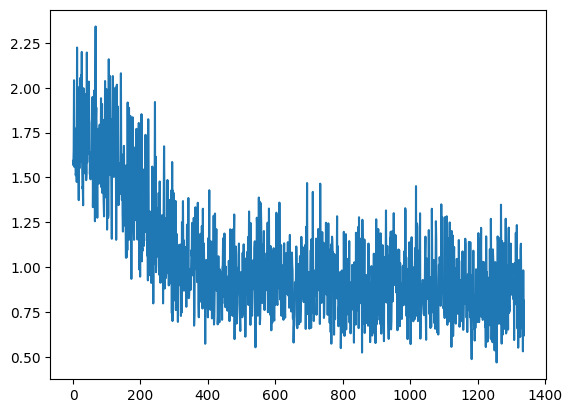

In [ ]:
plt.plot(train_loss)
plt.show()